<a href="https://colab.research.google.com/github/JakeLi2001/movie-search-engine/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# import libraries
import numpy as np
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download(['punkt', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import and Inspect Data

In [3]:
# import data
movies = pd.read_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/movies_metadata.csv', low_memory=False) # replace with your own path
keywords = pd.read_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/keywords.csv')                        # replace with your own path

In [4]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [6]:
# check dataframe shape (rows, columns)
print('movies:', movies.shape, '\n')
print('keywords:', keywords.shape)

movies: (45466, 24) 

keywords: (46419, 2)


In [7]:
# check data types
print('movies:')
print(movies.dtypes, '\n')

print('keywords:')
print(keywords.dtypes)

movies:
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object 

keywords:
id           int64
keywords    object
dtype: object


In [8]:
# convert data types 
movies = movies.convert_dtypes()
keywords = keywords.convert_dtypes()

print('movies:')
print(movies.dtypes, '\n')

print('keywords:')
print(keywords.dtypes)

movies:
adult                     string
belongs_to_collection     string
budget                    string
genres                    string
homepage                  string
id                        string
imdb_id                   string
original_language         string
original_title            string
overview                  string
popularity                string
poster_path               string
production_companies      string
production_countries      string
release_date              string
revenue                    Int64
runtime                    Int64
spoken_languages          string
status                    string
tagline                   string
title                     string
video                    boolean
vote_average             Float64
vote_count                 Int64
dtype: object 

keywords:
id           Int64
keywords    string
dtype: object


# Data Cleaning & Merge Dataframes

In [9]:
# check why the id column in movies is a string by showing rows where id is not pure digits
print(movies[~movies['id'].astype(str).str.isdigit()]['id'], '\n')
# filter out ids that contains values other than digits
movies_cleaned = movies.loc[movies['id'].astype(str).str.isdigit()].copy()
movies_cleaned['id'] = movies_cleaned['id'].astype('int64')

# convert release_date from string to date
movies_cleaned['release_date'] = pd.to_datetime(movies_cleaned['release_date'], errors='coerce') # invalid dates will result in Nat

print('Check movies data types again:', '\n', movies_cleaned.dtypes)

19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: string 

Check movies data types again: 
 adult                            string
belongs_to_collection            string
budget                           string
genres                           string
homepage                         string
id                                int64
imdb_id                          string
original_language                string
original_title                   string
overview                         string
popularity                       string
poster_path                      string
production_companies             string
production_countries             string
release_date             datetime64[ns]
revenue                           Int64
runtime                           Int64
spoken_languages                 string
status                           string
tagline                          string
title                            string
video                           boolean
v

In [10]:
# check range of release_date
print('Minimum movie release date:', movies_cleaned['release_date'].min())
print('Maximum movie release date:', movies_cleaned['release_date'].max())

# filter out movies that were released before 2000
movies_cleaned = movies_cleaned[movies_cleaned['release_date'] >= '2000-01-01 00:00:00']
print('Check movies dataframe shape:', movies_cleaned.shape)

Minimum movie release date: 1874-12-09 00:00:00
Maximum movie release date: 2020-12-16 00:00:00
Check movies dataframe shape: (24007, 24)


In [11]:
# keep only movies that are in English
movies_cleaned = movies_cleaned[movies_cleaned['original_language'] == 'en']
print('Check movies dataframe shape:', movies_cleaned.shape)

Check movies dataframe shape: (16657, 24)


In [12]:
# check nulls
print('movies:')
print(movies_cleaned.isna().sum(), '\n')

print('keywords:')
print(keywords.isna().sum())

movies:
adult                        0
belongs_to_collection    15093
budget                       0
genres                       0
homepage                 10950
id                           0
imdb_id                      6
original_language            0
original_title               0
overview                    30
popularity                   0
poster_path                166
production_companies         0
production_countries         0
release_date                 0
revenue                      0
runtime                      0
spoken_languages             0
status                      44
tagline                   8160
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64 

keywords:
id          0
keywords    0
dtype: int64


In [13]:
# drop movies columns that have too many nulls
print('# of columns before dropping:', movies_cleaned.shape[1])
movies_cleaned.drop(['belongs_to_collection', 'homepage', 'tagline'], axis=1, inplace=True)
print('# of columns after dropping:', movies_cleaned.shape[1])

# of columns before dropping: 24
# of columns after dropping: 21


In [14]:
# drop rows where overview is missing
movies_cleaned = movies_cleaned.dropna(subset='overview')

In [15]:
# check id duplicates
print('movies:')
print(movies_cleaned.id.duplicated().value_counts(), '\n')

print('keywords:')
print(keywords.id.duplicated().value_counts())

movies:
False    16618
True         9
Name: id, dtype: int64 

keywords:
False    45432
True       987
Name: id, dtype: int64


In [16]:
# drop duplicated id
movies_cleaned = movies_cleaned.drop_duplicates(subset='id')
keywords = keywords.drop_duplicates(subset='id')

In [17]:
# check dataframe shape
print('movies:')
print(movies_cleaned.shape, '\n')

print('keywords:')
print(keywords.shape)

movies:
(16618, 21) 

keywords:
(45432, 2)


In [19]:
# merge the 2 dataframes
df = movies_cleaned.merge(keywords, on='id')
df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,keywords
0,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",131232,tt0333373,en,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,/jo4n8M8EHedIuatB39C8EEmJBH8.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2002-03-20,0,86,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Two Friends,False,0.0,0,[]
1,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",79782,tt1684935,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.14713,/lUmJiBTKdesFDkgSvV9zecCgNO6.jpg,[],[],2010-05-25,0,110,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",Released,Venice,False,7.5,4,[]
2,False,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",141210,tt2250194,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,/pQpyEmFTGaox4yLuUXmiD2IDIbA.jpg,[],[],2013-10-12,0,6,[],Released,The Sleepover,False,8.0,1,[]
3,False,0,"[{'id': 18, 'name': 'Drama'}]",143750,tt2140519,en,The Farmer's Wife,"As her surroundings are invaded by outsiders, ...",0.211754,/ePPNVWyIKYBdsGrOrYVaPKM8DlM.jpg,[],[],2012-06-20,0,18,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Farmer's Wife,False,10.0,1,"[{'id': 214549, 'name': 'short'}]"
4,False,0,"[{'id': 99, 'name': 'Documentary'}]",84198,tt1736049,en,A Place at the Table,"Using personal stories, this powerful document...",0.501046,/jn8L1QdWWX5c0NUOLjzaSXtZrbt.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-22,0,84,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Place at the Table,False,6.9,7,"[{'id': 187056, 'name': 'woman director'}]"


In [20]:
df.shape

(16618, 22)

In [21]:
df.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_average', 'vote_count', 'keywords'],
      dtype='object')

In [22]:
# export dataframe as CSV 
# df.to_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/merged_df.csv', index=False)

# Data Visualization

In [23]:
df = pd.read_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/merged_df.csv')
df = df.convert_dtypes()

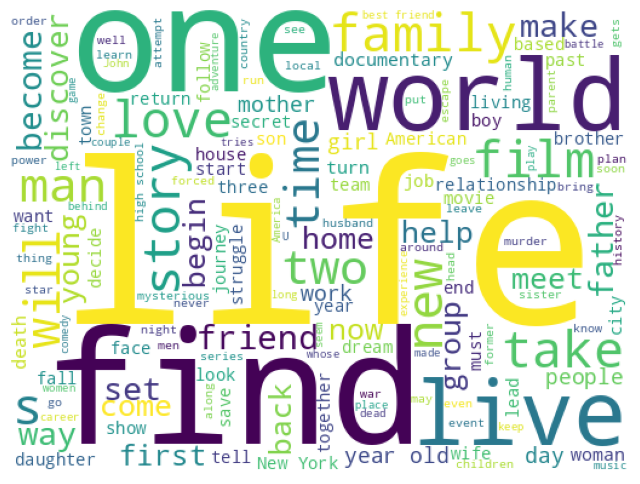

In [24]:
# wordcloud to analyze what's the most frequent word in the overview column before preprocessing
plt.subplots(figsize = (8,8))

wordcloud = WordCloud(max_words=150, background_color='white', width=512, height=384).generate(' '.join(df['overview']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
# plt.savefig('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/images/overview_wordcloud.png')
plt.show()

In [25]:
# Movie count per year
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day
df.head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,keywords,release_year,release_month,release_day
0,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",131232,tt0333373,en,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,/jo4n8M8EHedIuatB39C8EEmJBH8.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2002-03-20,0,86,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Two Friends,False,0.0,0,[],2002,3,20
1,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",79782,tt1684935,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.14713,/lUmJiBTKdesFDkgSvV9zecCgNO6.jpg,[],[],2010-05-25,0,110,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",Released,Venice,False,7.5,4,[],2010,5,25
2,False,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",141210,tt2250194,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,/pQpyEmFTGaox4yLuUXmiD2IDIbA.jpg,[],[],2013-10-12,0,6,[],Released,The Sleepover,False,8.0,1,[],2013,10,12


In [26]:
movie_count_df = pd.DataFrame(data={'movie_count': df.groupby(['release_year'])['id'].count()})
movie_count_df.dtypes

movie_count    int64
dtype: object

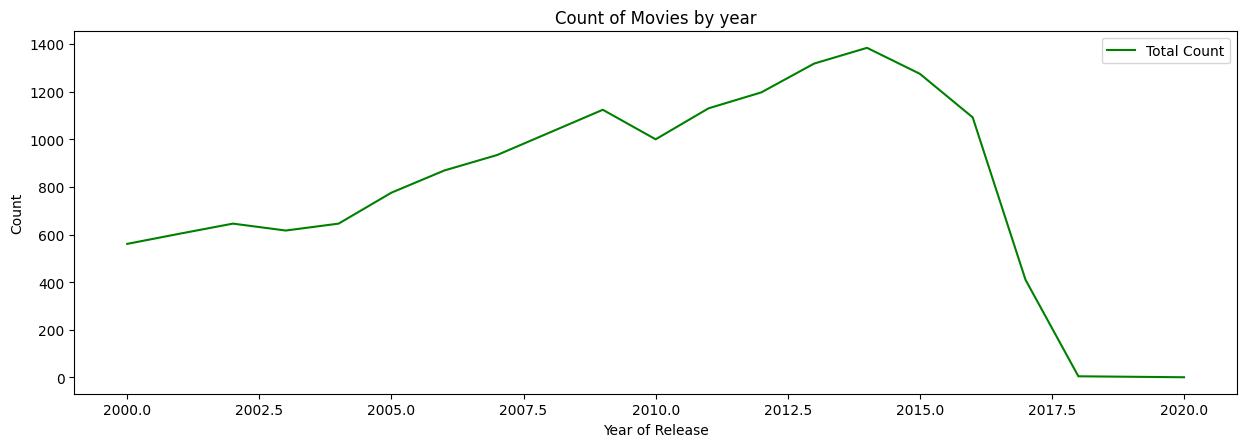

In [27]:
#Plot Count of movies per year

movie_count_df = pd.DataFrame(data={'movie_count': df.groupby(['release_year'])['id'].count()})

# Create a Figure
fig = plt.figure(figsize=(15,16))
# Set up Axes
ax1 = fig.add_subplot(311)
ax1.plot(movie_count_df.index, movie_count_df['movie_count'] , 'green', label='Total Count')
ax1.set_xlabel('Year of Release')
ax1.set_ylabel('Count')
ax1.set_title('Count of Movies by year')
ax1.legend()

Text(0.5, 1.0, 'Budget/Revenue vs Year')

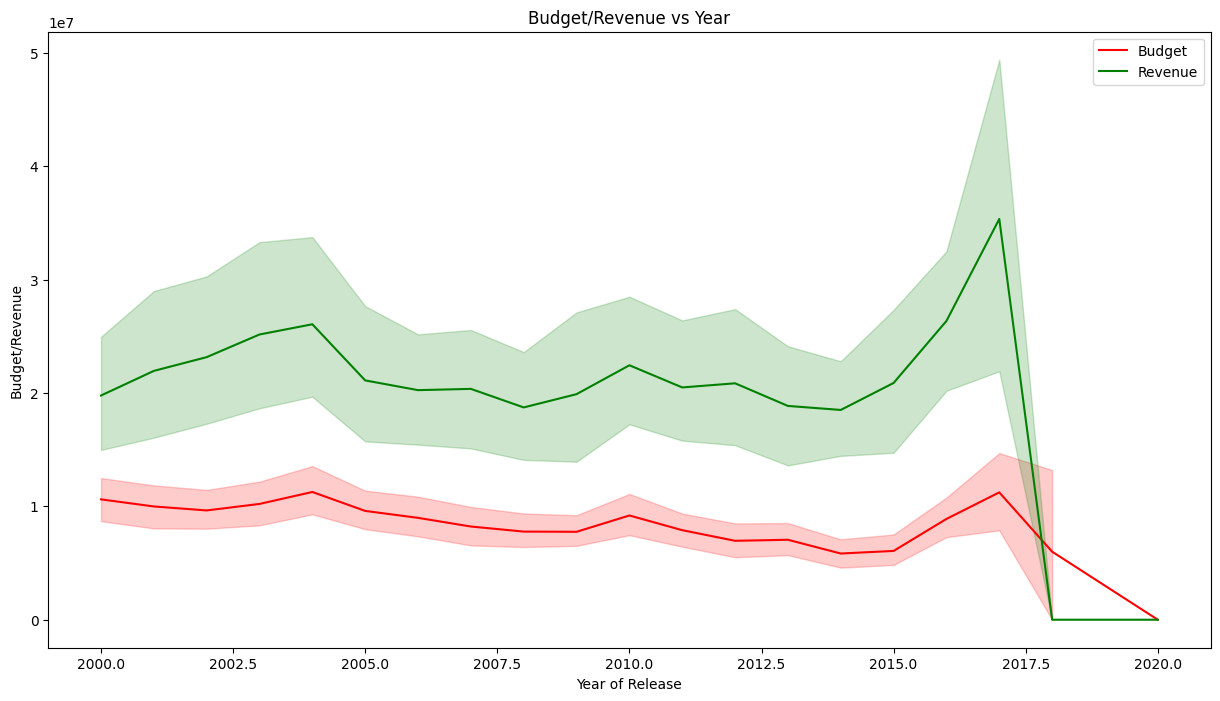

In [28]:
# Plot of mean of budget and revenue vs Year
# Create a Figure
fig = plt.figure(figsize=(15,8))
# Set up Axes
ax = fig.add_subplot(111)
sns.lineplot(x="release_year", y="budget", data=df, color="red", label="Budget")
sns.lineplot(x="release_year", y="revenue", data=df, color="green", label="Revenue")
ax.set_xlabel('Year of Release')
ax.set_ylabel('Budget/Revenue')
ax.set_title('Budget/Revenue vs Year')

# Text Preprocessing

In [29]:
merged_df = pd.read_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/merged_df.csv')
merged_df.head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,keywords
0,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",131232,tt0333373,en,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,/jo4n8M8EHedIuatB39C8EEmJBH8.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2002-03-20,0,86,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Two Friends,False,0.0,0,[]
1,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",79782,tt1684935,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.147130,/lUmJiBTKdesFDkgSvV9zecCgNO6.jpg,[],[],2010-05-25,0,110,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",Released,Venice,False,7.5,4,[]
2,False,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",141210,tt2250194,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,/pQpyEmFTGaox4yLuUXmiD2IDIbA.jpg,[],[],2013-10-12,0,6,[],Released,The Sleepover,False,8.0,1,[]


In [30]:
merged_df['genres'] = merged_df['genres'].apply(lambda x: re.sub('[\[\]{}\'0-9:,]', '', str(x)))
merged_df['genres'] = merged_df['genres'].apply(lambda x: str(x).replace('id', '').replace('name', ''))

merged_df['keywords'] = merged_df['keywords'].apply(lambda x: re.sub('[\[\]{}\'0-9:,]', '', str(x)))
merged_df['keywords'] = merged_df['keywords'].apply(lambda x: str(x).replace('id', '').replace('name', ''))

merged_df.head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,keywords
0,False,0,Drama Foreign,131232,tt0333373,en,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,/jo4n8M8EHedIuatB39C8EEmJBH8.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2002-03-20,0,86,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Two Friends,False,0.0,0,
1,False,0,Drama Romance,79782,tt1684935,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.147130,/lUmJiBTKdesFDkgSvV9zecCgNO6.jpg,[],[],2010-05-25,0,110,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",Released,Venice,False,7.5,4,
2,False,0,Comedy Horror,141210,tt2250194,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,/pQpyEmFTGaox4yLuUXmiD2IDIbA.jpg,[],[],2013-10-12,0,6,[],Released,The Sleepover,False,8.0,1,


In [31]:
merged_df["summary"] = merged_df["overview"].astype(str) + merged_df["genres"].astype(str) + merged_df["keywords"].astype(str)
merged_df.head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,keywords,summary
0,False,0,Drama Foreign,131232,tt0333373,en,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,/jo4n8M8EHedIuatB39C8EEmJBH8.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2002-03-20,0,86,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Two Friends,False,0.0,0,,"Two Sicilian friends, Nunzio and Pino, share t..."
1,False,0,Drama Romance,79782,tt1684935,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.147130,/lUmJiBTKdesFDkgSvV9zecCgNO6.jpg,[],[],2010-05-25,0,110,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",Released,Venice,False,7.5,4,,An atmospheric coming-of-age story featuring a...
2,False,0,Comedy Horror,141210,tt2250194,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,/pQpyEmFTGaox4yLuUXmiD2IDIbA.jpg,[],[],2013-10-12,0,6,[],Released,The Sleepover,False,8.0,1,,"The town of Derry has a secret, but no one tol..."


In [32]:
# lower case and tokenize
merged_df['tokens'] = merged_df['summary'].apply(str.lower).apply(word_tokenize)
print(merged_df['tokens'][0])

['two', 'sicilian', 'friends', ',', 'nunzio', 'and', 'pino', ',', 'share', 'the', 'same', 'apartment', 'in', 'turin', '.', 'nunzio', 'works', 'in', 'a', 'factory', 'but', 'is', 'laid', 'off', 'because', 'of', 'his', 'illness', '.', 'pino', ',', 'on', 'the', 'other', 'hand', ',', 'is', 'a', 'mysterious', 'man', 'and', 'he', 'is', 'always', 'traveling', 'because', 'of', 'his', 'work', '.', 'nunzio', 'would', 'very', 'much', 'like', 'to', 'know', 'what', 'his', 'friend', 'is', 'doing', 'for', 'a', 'living', 'but', 'pino', 'will', 'not', 'tell', 'him', '.', 'nunzio', 'spends', 'his', 'free', 'time', 'the', 'best', 'he', 'can', 'in', 'his', 'friend', "'s", 'absences', '.', 'he', 'ends', 'up', 'falling', 'in', 'love', 'with', 'maria', ',', 'a', 'commercial', 'employee', ',', 'whereas', 'his', 'health', 'condition', 'deteriorates', '...', 'drama', 'foreign']


In [33]:
# remove stop words and words that's not alphabetical
stop_words = stopwords.words('english')
merged_df['tokens'] = merged_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words and word.isalpha()])

print(merged_df['tokens'][0])

['two', 'sicilian', 'friends', 'nunzio', 'pino', 'share', 'apartment', 'turin', 'nunzio', 'works', 'factory', 'laid', 'illness', 'pino', 'hand', 'mysterious', 'man', 'always', 'traveling', 'work', 'nunzio', 'would', 'much', 'like', 'know', 'friend', 'living', 'pino', 'tell', 'nunzio', 'spends', 'free', 'time', 'best', 'friend', 'absences', 'ends', 'falling', 'love', 'maria', 'commercial', 'employee', 'whereas', 'health', 'condition', 'deteriorates', 'drama', 'foreign']


In [34]:
# stem words
stemmer = SnowballStemmer('english')
merged_df['stemmed_tokens'] = merged_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
print(merged_df['stemmed_tokens'][0])

['two', 'sicilian', 'friend', 'nunzio', 'pino', 'share', 'apart', 'turin', 'nunzio', 'work', 'factori', 'laid', 'ill', 'pino', 'hand', 'mysteri', 'man', 'alway', 'travel', 'work', 'nunzio', 'would', 'much', 'like', 'know', 'friend', 'live', 'pino', 'tell', 'nunzio', 'spend', 'free', 'time', 'best', 'friend', 'absenc', 'end', 'fall', 'love', 'maria', 'commerci', 'employe', 'wherea', 'health', 'condit', 'deterior', 'drama', 'foreign']


In [35]:
# combine tokens into a single string
merged_df['cleaned_summary'] = merged_df['stemmed_tokens'].apply(lambda x: ' '.join(x))
print(merged_df['cleaned_summary'][0])

two sicilian friend nunzio pino share apart turin nunzio work factori laid ill pino hand mysteri man alway travel work nunzio would much like know friend live pino tell nunzio spend free time best friend absenc end fall love maria commerci employe wherea health condit deterior drama foreign


In [36]:
merged_df.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_average', 'vote_count', 'keywords', 'summary', 'tokens',
       'stemmed_tokens', 'cleaned_summary'],
      dtype='object')

In [39]:
# subset columns and export merged dataframe to CSV
merged_df = merged_df[merged_df.columns.difference(['summary', 'tokens', 'stemmed_tokens'])]
# merged_df.to_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/cleaned_df.csv', index=False)

# TF-IDF Vectorizer

In [40]:
cleaned_df = pd.read_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/cleaned_df.csv')
cleaned_df.head(3)

,adult,budget,cleaned_summary,genres,id,imdb_id,keywords,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,0,two sicilian friend nunzio pino share apart tu...,Drama Foreign,131232,tt0333373,NaN,en,Due Amici,"Two Sicilian friends, Nunzio and Pino, share t...",0.003949,/jo4n8M8EHedIuatB39C8EEmJBH8.jpg,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2002-03-20,0,86,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,Two Friends,False,0.0,0
1,False,0,atmospher stori featur imagin young boy name m...,Drama Romance,79782,tt1684935,NaN,en,Wenecja,An atmospheric coming-of-age story featuring a...,0.147130,/lUmJiBTKdesFDkgSvV9zecCgNO6.jpg,[],[],2010-05-25,0,110,"[{'iso_639_1': 'pl', 'name': 'Polski'}]",Released,Venice,False,7.5,4
2,False,0,town derri secret one told new kid gon na long...,Comedy Horror,141210,tt2250194,NaN,en,The Sleepover,"The town of Derry has a secret, but no one tol...",0.135596,/pQpyEmFTGaox4yLuUXmiD2IDIbA.jpg,[],[],2013-10-12,0,6,[],Released,The Sleepover,False,8.0,1


In [41]:
# check for duplicated titles
cleaned_df.title.duplicated().sum()

442

In [42]:
# sort by release_date, remove duplicated title and keep the most recent title
cleaned_df = cleaned_df.sort_values(by='release_date')
cleaned_df.drop_duplicates(subset='title', keep='last', inplace=True)

In [43]:
# descriptive summary of the number of words in the cleaned_summary column
cleaned_df['num_words'] = cleaned_df['cleaned_summary'].apply(lambda x:len(str(x).split()))
cleaned_df['num_words'].describe()

count    16176.000000
mean        37.350890
std         20.278028
min          1.000000
25%         22.000000
50%         34.000000
75%         49.000000
max        194.000000
Name: num_words, dtype: float64

In [44]:
# remove rows where the number of words for the summary is less than 22
cleaned_df = cleaned_df[cleaned_df['num_words']>= 22]

**IMDB weighted avg formula:**

Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]
where,

*   v is the number of votes for the movie;
*   m is the minimum votes required to be listed in the chart;
*   R is the average rating of the movie; and
*   C is the mean vote across the whole report.

Now we can find the values of v,m,R,C.

For reference to formula: https://www.reddit.com/r/statistics/comments/1niai5/imbd_weighted_average/

In [45]:
# create variable to calcuate weighted_rating
C = cleaned_df['vote_average'].mean()
m = cleaned_df['vote_count'].quantile(0.2)
cleaned_df = cleaned_df.loc[cleaned_df['vote_count'] >= m]
cleaned_df.shape

(9873, 24)

In [46]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
 
cleaned_df['weighted_rating'] = cleaned_df.apply(weighted_rating, axis=1)

#Sorting movies based on score calculated above
cleaned_df = cleaned_df.sort_values('weighted_rating', ascending=False)

#Printing the top 15 movies
cleaned_df.reset_index(drop=True).head(3)

,adult,budget,cleaned_summary,genres,id,imdb_id,keywords,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,num_words,weighted_rating
0,False,0,david attenborough present documentari seri ex...,Documentary,420714,tt5491994,mountain island earth jungle mi...,en,Planet Earth II,David Attenborough presents a documentary seri...,5.651997,/uy5QoTu8fc6fGXMCTMbpQJFUEB0.jpg,"[{'name': 'BBC', 'id': 5996}, {'name': 'France...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2016-11-06,0,300,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Planet Earth II,False,9.5,50,24,9.213144
1,False,0,documentari miniseri describ maker definit loo...,Documentary,192040,tt0795176,miniseries great cinematpgraphy,en,Planet Earth,A documentary miniseries described by its make...,4.501137,/zX2tjZXInTpKqFWI8Tf9LYeCg97.jpg,"[{'name': 'BBC', 'id': 5996}, {'name': 'Discov...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-12-10,0,550,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Planet Earth,False,8.8,176,38,8.729499
2,False,0,second visual album collect short film beyoncé...,Music,394269,tt5662106,poetry southern usa pop culture em...,en,Lemonade,"The second ""visual album"" (a collection of sho...",2.899155,/AsVFfBqCqy1ifLLZyQEneeK1zFx.jpg,"[{'name': 'Parkwood Entertainment', 'id': 21435}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2016-04-23,0,65,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Lemonade,False,8.8,45,42,8.541015


In [47]:
# check index
cleaned_df.index

Int64Index([15846, 13871, 15402,  9990,  6712, 16123,  9563, 13929,  3382,
             7987,
            ...
             9455,  9876,  8845, 16271, 12921, 15758,  5180,  1337, 10740,
            15301],
           dtype='int64', length=9873)

In [48]:
# fix index so that it goes from 1 to 9873
cleaned_df.index = pd.RangeIndex(start=0, stop=0+len(cleaned_df), step=1)
cleaned_df.index

RangeIndex(start=0, stop=9873, step=1)

In [49]:
# export CSV
# cleaned_df.to_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/completed_df.csv', index=False)

# Movie Search Engine using Cosine Similarity

In [50]:
completed_df = pd.read_csv('/content/gdrive/MyDrive/College/CIS 4120/CIS4120 Project/data/completed_df.csv')

In [51]:
def get_recommendations(user_input):
    df = completed_df.copy()
    idx = len(df)
    df.loc[idx, 'cleaned_summary'] = str(user_input)
    
    # remove words that appear in more than 70% of the documents and words that appear in less than 3 documents
    tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=3) 
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_summary'].astype('str'))
    tfidf_array = tfidf_matrix.toarray()
    cos_sim = cosine_similarity(tfidf_array, tfidf_array)

    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    
    result = df[['title', 'release_date', 'genres', 'overview', 'weighted_rating']].iloc[movie_indices]
    result = result.sort_values(by='weighted_rating', ascending=False)
    return result

In [54]:
get_recommendations('superheros, a lot of combat, friendship, in space')

,title,release_date,genres,overview,weighted_rating
358,Rogue One: A Star Wars Story,2016-12-14,Action Adventure Science Fiction,A rogue band of resistance fighters unite for ...,7.398614
569,Miss You Already,2015-09-12,Comedy Drama Romance,The friendship between two life-long girlfrien...,7.271652
3233,Life,2017-03-22,Horror Science Fiction Thriller,The six-member crew of the International Space...,6.298630
3779,Just Buried,2007-09-09,Comedy Drama,A young man inherits a nearly bankrupt funeral...,6.187907
4788,Space Station 3D,2002-04-17,Documentary,Some 220 miles above Earth lies the Internatio...,5.973984
5114,Solaris,2002-11-27,Drama Science Fiction Mystery Romance,Upon arrival at the space station orbiting an ...,5.897146
5533,Lockout,2012-04-12,Action Thriller Science Fiction,"Set in the near future, Lockout follows a fals...",5.799049
7870,Tunnel Rats,2008-05-31,Action Drama War,During the Vietnam War [1959-1975] a special U...,5.181145
8029,Approaching the Unknown,2016-06-03,Thriller Drama Science Fiction,Captain William Stanaforth is on a one-way sol...,5.122686
8033,Space Chimps,2008-07-17,Animation Family,Circus monkey Ham III works in a circus where ...,5.119903


In [53]:
get_recommendations('robots time travel zombie')

,title,release_date,genres,overview,weighted_rating
49,11.22.63,2016-02-15,Drama History Thriller,An English teacher travels back in time to pre...,7.956266
1105,Happy Accidents,2000-01-25,Comedy Romance Science Fiction,A comedy that pays tribute to the science fict...,6.969106
1587,Stargate: Continuum,2008-07-29,Adventure Science Fiction,Ba'al travels back in time and prevents the St...,6.769740
1801,The Time Traveler's Wife,2009-08-14,Drama Romance Fantasy,"Due to a genetic disorder, handsome librarian ...",6.694762
2713,Rewind,2013-08-26,Science Fiction,Revolves around a team of military field opera...,6.447633
2872,Project Almanac,2015-01-29,Science Fiction Thriller,A group of teens discover secret plans of a ti...,6.396771
4170,ARQ,2016-09-09,Science Fiction Thriller,Two old friends living in a dystopic future be...,6.094505
4613,Kate & Leopold,2001-12-25,Comedy Fantasy Romance Science Fic...,When her scientist ex-boyfriend discovers a po...,5.996566
8060,The Butterfly Effect 3: Revelations,2009-01-09,Science Fiction Thriller Drama Crime,The story revolves around a man trying to unco...,5.113023
8172,Paradox,2016-04-22,Action Science Fiction,A group of scientists are experimenting with t...,5.066046
